In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
!pip install datasets transformers huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.6.1
    Uninstalling fsspec-2024.6.1:
      Successfully uninstalled fsspec-2024.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requ

In [ ]:
!apt-get install git-lfs

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
from datasets import load_dataset
imdb = load_dataset("imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_dataset
imdb = load_dataset("imdb", download_mode="reuse_cache_if_exists", cache_dir="/content/sample_data")


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
print(imdb.shape)
print(imdb['train'].shape)

{'train': (25000, 2), 'test': (25000, 2), 'unsupervised': (50000, 2)}
(25000, 2)


In [ ]:
small_train_dataset = imdb["train"].shuffle(seed=42).select([i for i in list(range(3000))])
small_test_dataset = imdb["test"].shuffle(seed=42).select([i for i in list(range(300))])

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
   return tokenizer(examples["text"], truncation=True)

tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [ ]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import numpy as np
from datasets import load_metric

def compute_metrics(eval_pred):
   load_accuracy = load_metric("accuracy")
   load_f1 = load_metric("f1")

   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
   f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
   return {"accuracy": accuracy, "f1": f1}


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from transformers import TrainingArguments, Trainer

repo_name = "finetuning-sentiment-model-3000-samples"

training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=2e-5,
   per_device_train_batch_size=16,
   per_device_eval_batch_size=16,
   num_train_epochs=2,
   weight_decay=0.01,
   save_strategy="epoch",
   push_to_hub=True,
)

trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)


In [ ]:
trainer.train()


Step,Training Loss


TrainOutput(global_step=376, training_loss=0.28792038369686046, metrics={'train_runtime': 303.6318, 'train_samples_per_second': 19.761, 'train_steps_per_second': 1.238, 'total_flos': 782725021021056.0, 'train_loss': 0.28792038369686046, 'epoch': 2.0})

In [ ]:
trainer.evaluate()


<ipython-input-12-b1430cee0b64>:5: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  load_accuracy = load_metric("accuracy")


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for f1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/f1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


{'eval_loss': 0.35078179836273193,
 'eval_accuracy': 0.8666666666666667,
 'eval_f1': 0.8726114649681529,
 'eval_runtime': 60.9267,
 'eval_samples_per_second': 4.924,
 'eval_steps_per_second': 0.312,
 'epoch': 2.0}

In [ ]:
trainer.push_to_hub()


Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1721823082.53a23eee0395.317.0:   0%|          | 0.00/5.13k [00:00<?, ?B/s]

events.out.tfevents.1721823503.53a23eee0395.317.1:   0%|          | 0.00/457 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/RjmRajaBabu/finetuning-sentiment-model-3000-samples/commit/898a09f9c73a96df556aa5e873e063225a7033fd', commit_message='End of training', commit_description='', oid='898a09f9c73a96df556aa5e873e063225a7033fd', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
from transformers import pipeline

sentiment_model = pipeline(model="federicopascual/finetuning-sentiment-model-3000-samples")
sentiment_model(["I love this move", "This movie sucks!"])


config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/333 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'label': 'LABEL_1', 'score': 0.9558863043785095},
 {'label': 'LABEL_0', 'score': 0.9413502216339111}]

**Analyzing Tweets with Sentiment Analysis and Python**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


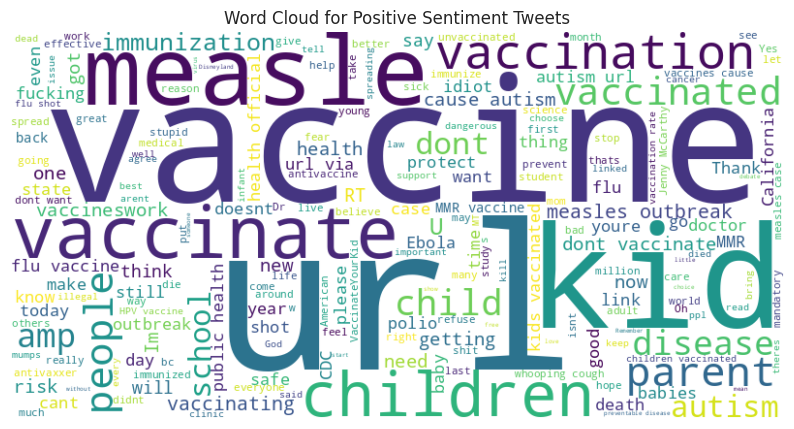

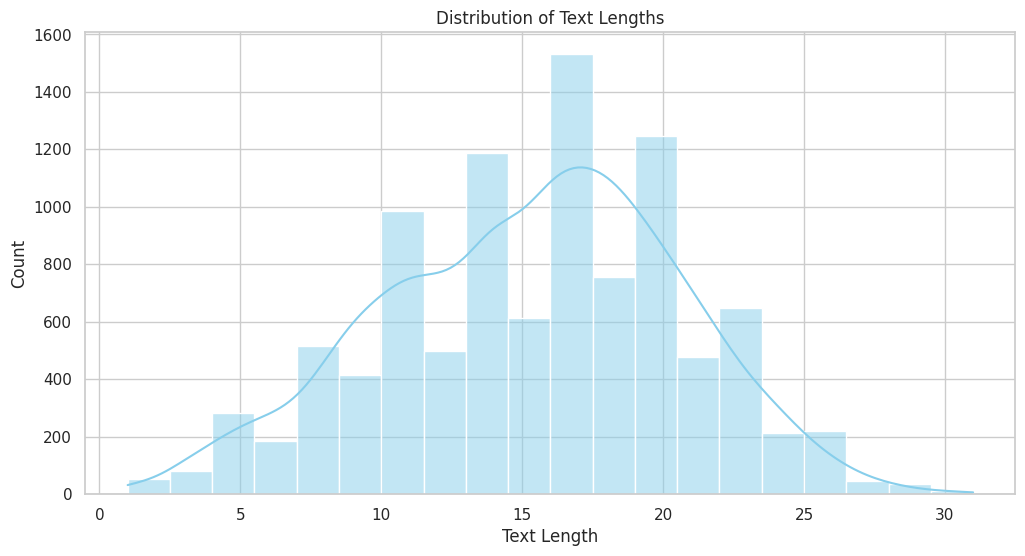

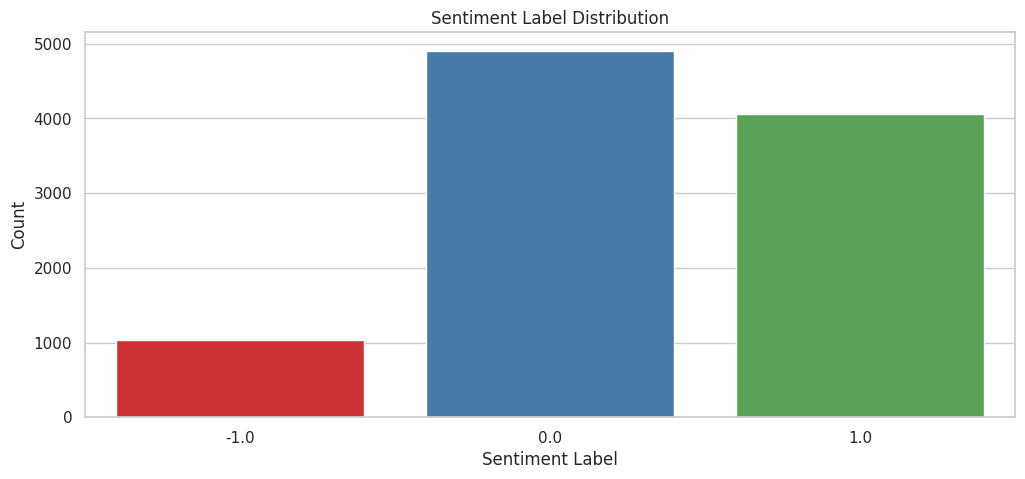

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
# Install required dependencies
!pip install -q datasets transformers huggingface_hub accelerate -U

# Load necessary libraries
import re
import pandas as pd
import numpy as np

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Deep learning
import torch
from torch import nn

# Scikit-Learn
from sklearn.model_selection import train_test_split

# Class imbalance
from sklearn.utils.class_weight import compute_class_weight

# Dataset preparation
from datasets import load_dataset, load_metric

# Transformers
from transformers import AutoTokenizer, TrainingArguments, Trainer, AutoModelForSequenceClassification, DataCollatorWithPadding

import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Check if GPU is available
torch.cuda.is_available()

# Set random seeds for PyTorch
seed = 12
torch.manual_seed(seed)

# Further set seeds for GPU operations if using CUDA
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)

# Load both train and test dataset
train = pd.read_csv('/content/drive/MyDrive/daaaa/Train.csv')
test = pd.read_csv('/content/drive/MyDrive/daaaa/Test.csv')

# Function to clean text
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'<user>', '', text)
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Apply the clean_text function to the 'safe_text' column
train['safe_text'] = train['safe_text'].apply(clean_text)

# Function to remove extra white spaces
def remove_extra_spaces(text):
   # Replace all whitespace characters with a single space
    text = re.sub(r'\s+', ' ', text)
    return text

# Apply the remove_extra_spaces function to the 'safe_text' column
train['safe_text'] = train['safe_text'].apply(remove_extra_spaces)

# Drop all missing values
train.dropna(inplace=True)

# Extract positive sentiment tweets
positive_tweets = train[train['label'] == 1]['safe_text']

# Generate and display a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_tweets))

# Set the fig size
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment Tweets')
plt.show()

# Calculate text lengths (the number of words) in the 'safe_text' column
text_lengths = train['safe_text'].apply(lambda x: len(x.split()))

# Set the style for Seaborn
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Using sns.histplot to create a histogram with Seaborn
sns.histplot(text_lengths, bins=20, kde=True, color="skyblue")

plt.title('Distribution of Text Lengths')  # Set the plot title
plt.xlabel('Text Length')  # Label for the x-axis
plt.ylabel('Count')  # Label for the y-axis
plt.show()  # Display the plot

# Create a bar plot
plt.figure(figsize=(12, 5))

sns.countplot(data=train, x='label', palette="Set1")

plt.title('Sentiment Label Distribution')  # Set the plot title
plt.xlabel('Sentiment Label')  # Label for the x-axis
plt.ylabel('Count')  # Label for the y-axis
plt.show()  # Display the plot

# perform a train validation split with 20% validation set size
X_train, X_val = train_test_split(train, test_size=0.2, random_state=12, stratify=train['label'])

# Save the training and validation set for reproducibility
X_train.to_csv('/content/drive/MyDrive/daaaa/training_set.csv', index=False)
X_val.to_csv('/content/drive/MyDrive/daaaa/validation_set.csv', index=False)

# Load the train and val dataset using the load_data function from datasets
data = load_dataset(path='csv', name='sentiment_analysis_data', data_files={
    'train': '/content/drive/MyDrive/daaaa/training_set.csv',
    'val': '/content/drive/MyDrive/daaaa/validation_set.csv'
},)

# Transform the labels
def transform_labels(label):
      label = label['label']
      num = 0
      if label == -1: # Negative Sentiment
          num = 0
      elif label == 0: # Neutral Sentiment
          num = 1
      elif label == 1: # Positive Sentiment
          num = 2
      return {'labels': num}

# Define the model name to be used for tokenization and modeling
MODEL_NAME = "distilbert-base-uncased-finetuned-sst-2-english"

# Create an instance of the tokenizer from the pre-trained model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Function to tokenize data
def tokenize_data(data):
    return tokenizer(data['safe_text'], padding='max_length', max_length=256)

# Tokenize the tweets
dataset = data.map(tokenize_data, batched=True)

# Transform labels and limit the columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

# Define the labels
labels = dataset['train']['labels']

# Apply the compute class weight function to calculate the class weight
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

# Define an instance of the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3, ignore_mismatched_sizes=True)

# Define training arguments with 5 epochs
training_args = TrainingArguments(
    "distilbert_covid_tweets_sentiment_analysis_model_trainer",
    num_train_epochs=3,
    load_best_model_at_end=True,
    evaluation_strategy="steps",
    save_strategy="steps"
)

# Define evaluation metrics
metric = load_metric("accuracy")

def compute_metrics(pred):
    logits, labels = pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

# Instantiate the training and validation sets with random state of 12
train_dataset = dataset["train"].shuffle(seed=12)
val_dataset = dataset["val"].shuffle(seed=12)

# Convert train data to PyTorch tensors to speed up training and add padding
data_collator_with_padding = DataCollatorWithPadding(tokenizer=tokenizer, padding="max_length", max_length=256, return_tensors="pt")

# Define Custom Trainer | Modify loss function and assign computed weights
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Instantiate the trainer for training
c_trainer = CustomTrainer(
                  model=model,
                  args=training_args,
                  train_dataset=train_dataset,
                  eval_dataset=val_dataset,
                  tokenizer=tokenizer,
                  data_collator=data_collator_with_padding,
                  compute_metrics=compute_metrics,
)

# Apply the trainer for training
c_trainer.train()

# Create a DataFrame from the training evaluations
data = pd.DataFrame({

    'Step': [500, 1000, 1500, 2000, 2500, 3000],
    'Training Loss': [0.899400, 0.796300, 0.611100, 0.618100, 0.424500, 0.363800],
    'Validation Loss': [0.769895, 0.733580, 0.839721, 0.787558, 1.023667, 1.057999],
    'Accuracy': [0.699000, 0.733000, 0.743500, 0.754500, 0.758500, 0.758500]
})

# Set the style for Seaborn (optional, for visual customization)
sns.set(style="whitegrid")

# Create a point plot using Seaborn
plt.figure(figsize=(12, 5))
sns.pointplot(data=data, x='Step', y='Training Loss', color='b', label='Training Loss')
sns.pointplot(data=data, x='Step', y='Validation Loss', color='g', label='Validation Loss')
sns.pointplot(data=data, x='Step', y='Accuracy', color='r', label='Accuracy')

plt.title('Training and Validation Metrics Over Steps')
plt.xlabel('Step')
plt.ylabel('Metric Value')
plt.legend(loc='upper right')
plt.show()

# Perform evaluation with the same trainer instance
evaluation_output = c_trainer.evaluate()

# Print the evaluation output
print(evaluation_output)


**Final** **code**

CUDA is available. Training on GPU.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
gcsfs 2024.6.1 requires fsspec==2024.6.1, but you have fsspec 2024.5.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.320300,0.303544,0.850000,0.851485
2,0.206700,0.359022,0.856667,0.864353
3,0.127500,0.430475,0.866667,0.871795


The repository for accuracy contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/accuracy.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


The repository for f1 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/f1.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


IMDB Evaluation Results: {'eval_loss': 0.4304746091365814, 'eval_accuracy': 0.8666666666666667, 'eval_f1': 0.8717948717948718, 'eval_runtime': 5.3802, 'eval_samples_per_second': 55.76, 'eval_steps_per_second': 3.531, 'epoch': 3.0}


ValueError: x and y must have same first dimension, but have shapes (56,) and (4,)

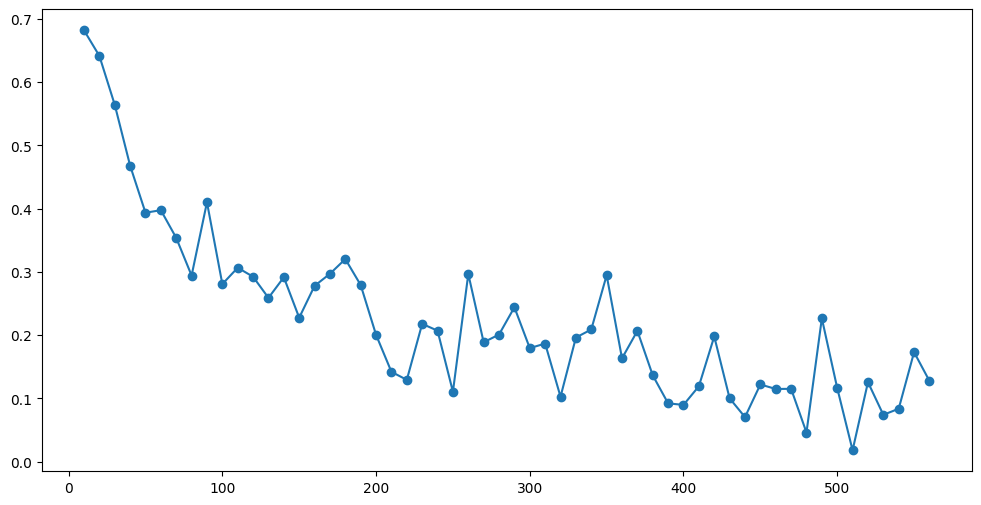

In [ ]:
import torch

# Check if GPU is available for training
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU.")
else:
    print("CUDA is not available. Training on CPU.")

# Install required libraries
!pip install -q datasets transformers huggingface_hub accelerate matplotlib seaborn wordcloud scikit-learn

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, load_metric
from wordcloud import WordCloud
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    pipeline,
)
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch import nn
import re
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

# Load IMDB dataset
imdb = load_dataset("imdb", cache_dir="/content/sample_data", download_mode="reuse_cache_if_exists")

# Create small subsets for training and testing
small_train_dataset = imdb["train"].shuffle(seed=42).select(range(3000))
small_test_dataset = imdb["test"].shuffle(seed=42).select(range(300))

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

# Tokenize data
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_train = small_train_dataset.map(preprocess_function, batched=True)
tokenized_test = small_test_dataset.map(preprocess_function, batched=True)

# Data collator for dynamic padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Load pre-trained model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# Define metric computation function
def compute_metrics(eval_pred):
    load_accuracy = load_metric("accuracy")
    load_f1 = load_metric("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = load_accuracy.compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_f1.compute(predictions=predictions, references=labels)["f1"]
    return {"accuracy": accuracy, "f1": f1}

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_total_limit=2
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()

# Print evaluation results
print(f"IMDB Evaluation Results: {eval_results}")

# Generate training and evaluation loss plots
def plot_metrics(log_history):
    train_loss = [log['loss'] for log in log_history if 'loss' in log]
    eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
    steps = [log['step'] for log in log_history if 'loss' in log]

    plt.figure(figsize=(12, 6))
    plt.plot(steps, train_loss, label='Training Loss', marker='o')
    plt.plot(steps, eval_loss, label='Evaluation Loss', marker='x')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training and Evaluation Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Plot metrics for IMDB data
plot_metrics(trainer.state.log_history)

# Analyze tweets with custom dataset
train_df = pd.read_csv('/content/drive/MyDrive/daaaa/Train.csv')

# Clean text function
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'<user>', '', text)  # Remove mentions
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    return text.strip()

# Apply text cleaning
train_df['safe_text'] = train_df['safe_text'].apply(clean_text)

# Drop missing values
train_df.dropna(inplace=True)

# Visualize positive sentiment tweets with word cloud
positive_tweets = train_df[train_df['label'] == 1]['safe_text']
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(positive_tweets))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Sentiment Tweets')
plt.show()

# Text length distribution
text_lengths = train_df['safe_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))
sns.histplot(text_lengths, bins=20, kde=True, color="skyblue")
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

# Sentiment label distribution
plt.figure(figsize=(12, 5))
sns.countplot(data=train_df, x='label', palette="Set1")
plt.title('Sentiment Label Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
plt.show()

# Train-test split
X_train, X_val = train_test_split(train_df, test_size=0.2, random_state=12, stratify=train_df['label'])

# Save train and validation sets
X_train.to_csv('/content/drive/MyDrive/daaaa/training_set.csv', index=False)
X_val.to_csv('/content/drive/MyDrive/daaaa/validation_set.csv', index=False)

# Load dataset
data = load_dataset(
    path='csv',
    data_files={
        'train': '/content/drive/MyDrive/daaaa/training_set.csv',
        'val': '/content/drive/MyDrive/daaaa/validation_set.csv'
    }
)

# Transform labels function
def transform_labels(label):
    return {'labels': label['label'] + 1}

# Tokenize data
def tokenize_data(data):
    return tokenizer(data['safe_text'], padding='max_length', max_length=256, truncation=True)

# Tokenize dataset
dataset = data.map(tokenize_data, batched=True)

# Transform labels
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

# Compute class weights
labels = dataset['train']['labels']
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)

# Define custom trainer with class weights
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get('logits')
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Instantiate custom trainer
custom_trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"].shuffle(seed=12),
    eval_dataset=dataset["val"].shuffle(seed=12),
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Train the model with custom trainer
custom_trainer.train()

# Evaluate custom model
custom_eval_results = custom_trainer.evaluate()

# Print evaluation results
print(f"Custom Dataset Evaluation Results: {custom_eval_results}")

# Plot metrics for custom dataset
plot_metrics(custom_trainer.state.log_history)
